Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
#del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
# skip_window: number of words before and after the selected word; together with the selected word, thses will form a span
# numj_skips: number of words picked from the span as the target words to the selected word
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
#    print ('data_index before i: {}'.format(data_index))
#    print ('buffer bofore i: {}'.format([reverse_dictionary[bi] for bi in buffer]))
#    print ('---------')
#   print ('---------')
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
#        print ('data_index appended in i = {} step: {}'.format(i,data_index))
        buffer.append(data[data_index])
#        print ('buffer in i={} step:{}'.format(i,[reverse_dictionary[bi] for bi in buffer]))
#        print ('---------')
        data_index = (data_index + 1) % len(data)
    return batch, labels

batch_size = 16
print('data:', [reverse_dictionary[di] for di in data[:batch_size]])

for num_skips, skip_window in [(4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=batch_size, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(batch_size)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a', 'term', 'term', 'term', 'term', 'of', 'of', 'of', 'of']
    labels: ['term', 'anarchism', 'a', 'originated', 'as', 'originated', 'of', 'term', 'as', 'abuse', 'of', 'a', 'term', 'first', 'a', 'abuse']


Train a skip-gram model.

In [82]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True)) #sqrt of sum of squares of each row
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [83]:
data_index=0
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
          batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.220882
Nearest to these: purged, rerio, poz, knox, charlemagne, world, jfif, estimators,
Nearest to but: pianists, mychal, constructible, hypnotic, minuteman, jennie, laodicea, filmography,
Nearest to or: centrality, competitor, geezer, shortly, countess, besiege, fields, misunderstandings,
Nearest to six: ubiquitous, introductions, speght, taxable, wickedness, neoplatonic, recurrent, lichen,
Nearest to were: structure, handicaps, diffie, disorder, grist, motivating, wes, ghibellines,
Nearest to known: transmembrane, mildly, vincennes, spray, disagreed, halides, bal, responsa,
Nearest to time: taklamakan, kkk, trs, heterozygote, encodings, argos, fan, whereabouts,
Nearest to th: incite, detonated, macarthur, struct, tectonics, overturn, bat, kinases,
Nearest to in: magellanic, hovered, zhdanov, happening, thucydides, sway, nearing, trash,
Nearest to more: eftpos, cops, chrominance, fundraising, herder, pinus, caret, hamad,
Nearest to of: probably, 

In [84]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

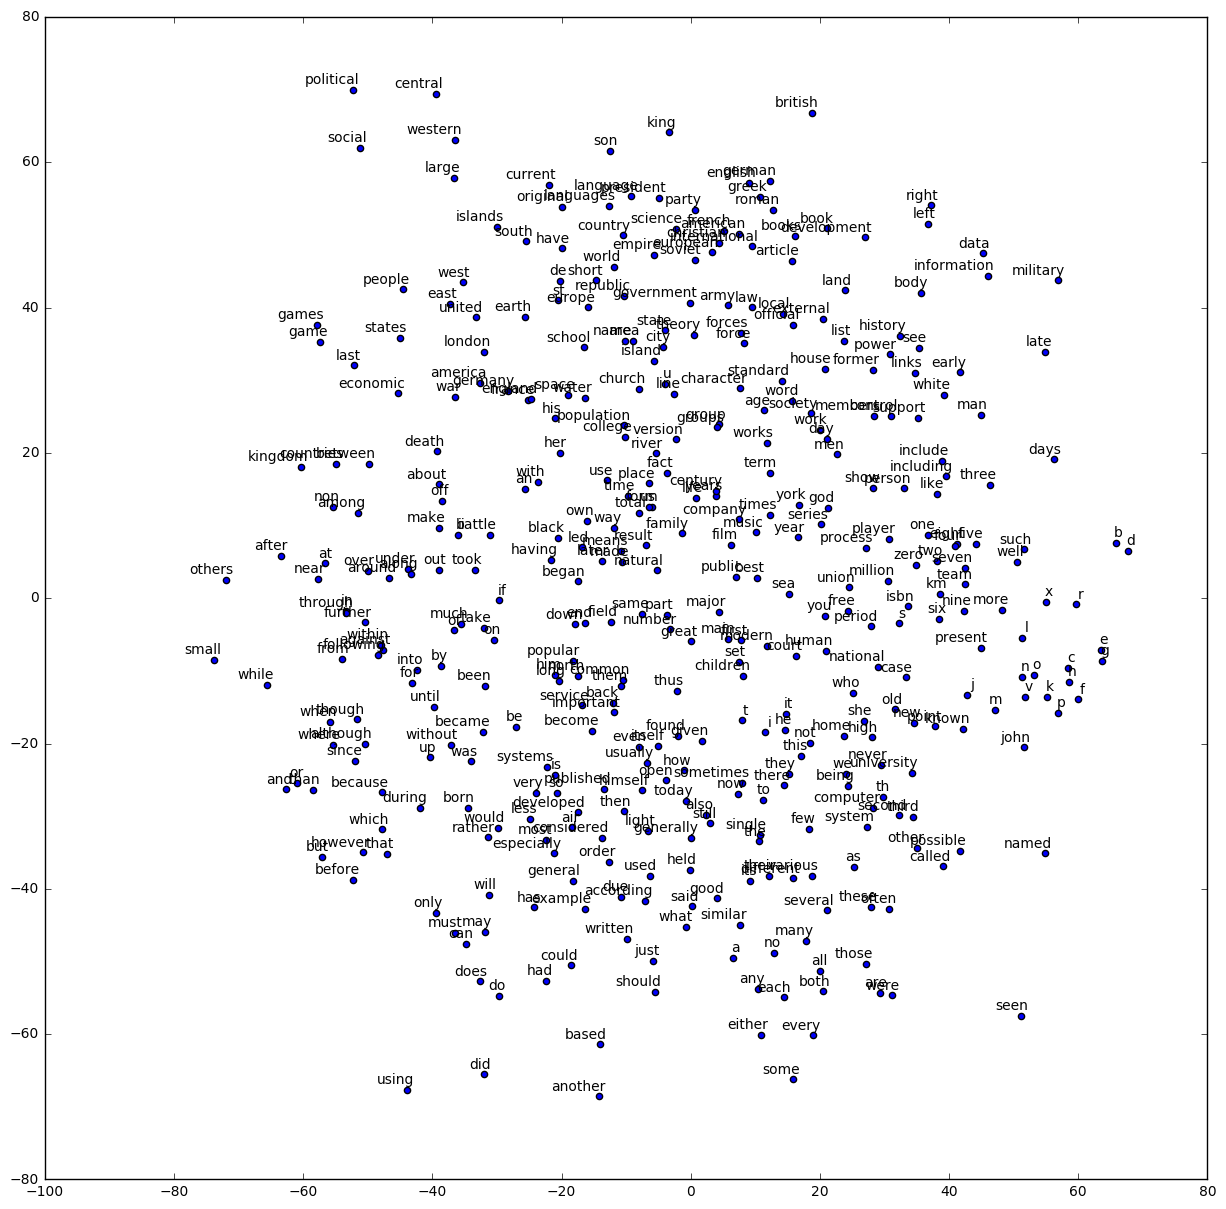

In [85]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

###### Little note on CBOW:
  - for a sentence: w[0] w[1] w[3] w[4] w[5] ..., feed the average of the embeddings of w[0],w[1], w[4],and w[5] into the softmax with the word index of w[3] as target label
  - skip_window is the number of words selected before and after the target word. in this case: skip_window = 2
###### Train results:
  - skip_window = 1 (amazing result!!):
    - Average loss at step 100000: 2.462981
    - Nearest to so: ensures, too, mahler, fifths, basquiat, tibeto, hilltop, rebadged,
    - Nearest to i: you, we, ii, iii, they, rightarrow, meyer, mozambique,
    - Nearest to no: any, little, manually, routledge, jeb, another, adb, pentastar,
    - Nearest to while: although, when, however, though, before, after, began, but,
    - Nearest to two: three, four, six, five, seven, eight, nine, zero,
    - Nearest to four: five, six, three, seven, eight, nine, zero, two,
    - Nearest to if: when, though, transjordan, where, before, since, hugely, whether,
    - Nearest to an: filmi, tartarus, strenuous, dama, homosexuals, alternates, bassists, marinus,
    - Nearest to american: british, italian, canadian, robert, tom, german, english, australian,
    - Nearest to his: her, their, my, its, your, our, the, whose,
    - Nearest to states: nations, kingdom, us, state, primacy, countries, memories, provinces,
    - Nearest to their: its, his, her, our, your, whose, my, the,
    - Nearest to three: four, five, seven, six, eight, two, nine, zero,
    - Nearest to will: would, can, could, should, must, may, might, cannot,
    - Nearest to who: repeatedly, which, he, often, she, gurdjieff, still, also,
    - Nearest to <font color='red'>years: days, months, decades, year, centuries, weeks, minutes, hours,</font>
  - skip_window = 8 (took longer to run):
    - Average loss at step 100000: 3.195080
    - Nearest to would: could, should, must, will, might, may, can, cannot,
    - Nearest to into: through, lurking, btr, beverley, sociobiology, eventually, from, towards,
    - Nearest to from: rem, commandos, through, into, vikings, before, rovere, suu,
    - Nearest to after: before, during, valery, until, when, toward, later, superiority,
    - Nearest to four: three, five, six, eight, seven, brooker, two, attestation,
    - Nearest to many: some, several, various, most, zhou, cleef, annals, judaism,
    - Nearest to <font color='red'>years: year, decades, days, hours, republik, period, dewitt, validity,</font>
    - Nearest to nine: eight, hues, tsing, shem, nana, thant, zirconium, seven,
    - Nearest to only: heated, all, even, never, schooled, menorah, reykjav, veered,
    - Nearest to time: least, times, overtaking, muad, cimbri, lauded, edits, tricky,
    - Nearest to for: typeface, celeste, tech, seljuk, beginnings, marais, signers, hexagram,
    - Nearest to these: different, they, adjectives, jervis, galatea, which, berkley, refutation,
    - Nearest to of: throughout, filial, astm, among, halliwell, following, idris, hospital,
    - Nearest to seven: six, eight, five, four, three, madame, irate, nine,
    - Nearest to th: twentieth, nineteenth, respectability, pelvis, ax, late, bc, harcourt,
    - Nearest to with: pathways, aardvarks, fingers, pai, moralistic, guevara, neurath, owen,

In [70]:
def generate_batch2(batch_size, skip_window):
# skip_window: number of words before and after the selected word; together with the selected word, thses will form a span
    global data_index
    assert batch_size > 2*skip_window
    batch = np.asarray([data[n:(n+skip_window)] + data[(n+skip_window+1):(n+2*skip_window+1)] for n in xrange(data_index , data_index + batch_size)],dtype = np.int32)
    labels = np.asarray([[data[n+skip_window]] for n in xrange(data_index , data_index + batch_size)], dtype=np.int32)
    data_index += batch_size
    return batch, labels

batch_size = 16
print('data:', [reverse_dictionary[di] for di in data[:batch_size]])

for skip_window in [2]:
    data_index = 0
    batch, labels = generate_batch2(batch_size=batch_size,skip_window=skip_window)
    print('\nwith skip_window = %d:' % (skip_window))
    print('    batch:', [[reverse_dictionary[bi] for bi in row] for row in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(batch_size)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']

with skip_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used'], ['of', 'abuse', 'used', 'against'], ['abuse', 'first', 'against', 'early'], ['first', 'used', 'early', 'working'], ['used', 'against', 'working', 'class'], ['against', 'early', 'class', 'radicals'], ['early', 'working', 'radicals', 'including'], ['working', 'class', 'including', 'the'], ['class', 'radicals', 'the', 'diggers'], ['radicals', 'including', 'diggers', 'of'], ['including', 'the', 'of', 'the'], ['the', 'diggers', 'the', 'english']]
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of']


In [76]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 8 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size,2*skip_window])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs and get the mean
    embed = tf.reduce_mean(tf.nn.embedding_lookup(embeddings, train_dataset),1)
    # Compute the least square loss
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed, labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True)) #sqrt of sum of squares of each row
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [77]:
num_steps = 100001
data_index=0

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch2(batch_size, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.560778
Nearest to would: oligopoly, azt, invoke, appoints, sums, cures, using, bombarded,
Nearest to into: lurking, kahane, progress, hawai, melds, aldermen, evolve, shelton,
Nearest to from: commandos, burmese, bryce, relationships, generating, vikings, hull, corea,
Nearest to after: valery, courtship, allure, pharaonic, york, eithne, oui, criticise,
Nearest to four: eicher, idiosyncrasies, naguib, hogarth, joannes, abhidharma, implicitly, lackluster,
Nearest to many: rankin, disappointing, voltages, fujiko, deadlines, regnum, cormac, nafta,
Nearest to years: bans, scathing, viral, blatantly, germans, dostoevsky, branding, reproduction,
Nearest to nine: unital, forseti, battery, progs, incarnation, climbs, limousine, retaining,
Nearest to only: mauser, lap, xenosaga, heated, schooled, tsinghua, feral, scribe,
Nearest to time: vma, icbm, encroaching, etsi, northeasterly, bhaktivedanta, stacks, accounted,
Nearest to for: typeface, proficient, marais

---
A simple tensorflow set up to test out functions
--

In [67]:
import tensorflow as tf

train_dataset = tf.constant([
                [1,2,4,5],
                [2,3,5,6]
                ])
embeddings = tf.constant(final_embeddings)
embed = tf.nn.embedding_lookup(embeddings, train_dataset)
avg_embed = tf.reduce_mean(embed,1)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

embed,avg_embed = sess.run([embed,avg_embed])


In [68]:
embed.shape

(2, 4, 128)

In [69]:
avg_embed.shape

(2, 128)